In [1]:
! nvidia-smi

Sun Mar 21 13:20:06 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports
The following packages are imported:
- tensorflow
- matplotlib
- numpy
- IPython


In [2]:
# import wandb

import tensorflow as tf
from tensorflow.keras.layers import *

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import IPython

# Data
- data_dir is the path to the images and the `results.csv`
- image_dir is the path exculsively to the images
- csv_file is the path to the `results.csv` file

In [3]:
data_dir = '../input/flickr-image-dataset/flickr30k_images'
image_dir = f'{data_dir}/flickr30k_images'
csv_file = f'{data_dir}/results.csv'

Here we read the csv file as a dataframe and make some observations from it.
For a quick EDA we are going to 
- check the shape of the dataframe
- check the names of the columns
- find out the unique image names there are

In [4]:
df = pd.read_csv(csv_file, delimiter='|')

print(f'[INFO] The shape of dataframe: {df.shape}')
print(f'[INFO] The columns in the dataframe: {df.columns}')
print(f'[INFO] Unique image names: {len(pd.unique(df["image_name"]))}')

[INFO] The shape of dataframe: (158915, 3)
[INFO] The columns in the dataframe: Index(['image_name', ' comment_number', ' comment'], dtype='object')
[INFO] Unique image names: 31783


A quick observation here is to see that the dataframe has `158915` elements but only `31783` image names. This means that there is a duplicacy involved. On further inspection we will see that each image has 5 unique captions attached to it ($31783\times 5=158915$)

While looking into the dataframe I found out that `19999` had some messed up entries. This has led me to manually change the entries in that row.

In [5]:
df.columns = ['image_name', 'comment_number', 'comment']
del df['comment_number']

# Under scrutiny I had found that 19999 had a messed up entry
df['comment'][19999] = ' A dog runs across the grass .'

# Image names now correspond to the absolute position
df['image_name'] = image_dir+'/'+df['image_name']

# <start> comment <end>
df['comment'] = "<start> "+df['comment']+" <end>"

In [6]:
# Shuffle the dataframe
df = df.sample(frac=1).reset_index(drop=True)
df.head()

,image_name,comment
0,../input/flickr-image-dataset/flickr30k_images...,<start> The dog that the two children are wal...
1,../input/flickr-image-dataset/flickr30k_images...,"<start> An Asian women , and a small Asian ch..."
2,../input/flickr-image-dataset/flickr30k_images...,<start> A young girl with blond-hair is playi...
3,../input/flickr-image-dataset/flickr30k_images...,<start> A man in a suit reading a from a piec...
4,../input/flickr-image-dataset/flickr30k_images...,<start> Two men working on a car engine in a ...


In [7]:
# SIZE = len(df)

# train_size = int(0.7* SIZE) 
# val_size = int(0.1* SIZE)
# test_size = int(0.2* SIZE)

# train_size, val_size, test_size

train_size = 60_000 
val_size = 10_000
test_size = 20_000

Splitting the dataframe accordingly

In [8]:
train_df = df.iloc[:train_size,:]
val_df = df.iloc[train_size:train_size+val_size,:]
test_df = df.iloc[train_size+val_size:train_size+val_size+test_size,:]

train_df.shape, val_df.shape, test_df.shape

((60000, 2), (10000, 2), (20000, 2))

<start>  A group of people are standing in front of parked bicycles on a corner with various carrying bags on the ground . <end>


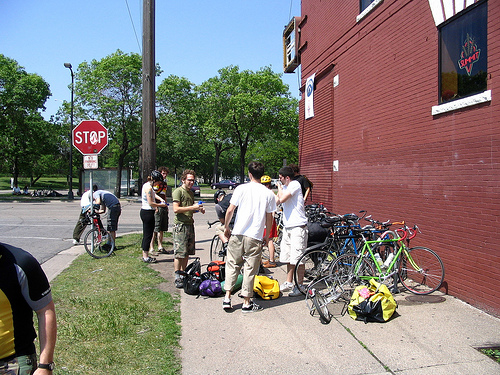

In [9]:
# Enter different indices.
index = 200

image_name = train_df['image_name'][index]
comment = train_df['comment'][index]

print(comment)

IPython.display.Image(filename=image_name)

# Text Handling
- Defined the size of the vocab which is `5000`.
- Initialized the Tokenizer class.
    - Standardized (all to lower case)
    - Filters the punctuations
    - Splits the text
    - Creates the vocabulary (`<start>, <end> and <unk>` is defined)

In [10]:
# Choose the top 10000 words from the vocabulary
top_k = 10000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                  oov_token="<unk>",
                                                  filters='!"#$%&()*+.,-/:;=?@[\]^_`{|}~')

Here we fit the `tokenizer` object on the captions. This helps in the updation of the vocab that the `tokenizer` object might have.

In the first iteration the vocabulary does not start from `0`. Both the dictionaries have 1 as the key or value.

In [11]:
# build the vocabulary
tokenizer.fit_on_texts(train_df['comment'])

In [12]:
# This is a sanity check function
def check_vocab(word):
    i = tokenizer.word_index[word]
    print(f"The index of the word: {i}")
    print(f"Index {i} is word {tokenizer.index_word[i]}")
    
check_vocab("pajama")

The index of the word: 4304
Index 4304 is word pajama


Here we are padding the sentences so that each of the sentences are of the same length.

In [13]:
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [14]:
# Create the tokenized vectors
train_seqs = tokenizer.texts_to_sequences(train_df['comment'])
val_seqs = tokenizer.texts_to_sequences(val_df['comment'])
test_seqs = tokenizer.texts_to_sequences(test_df['comment'])

In [15]:
# Pad each vector to the max_length of the captions
# If you do not provide a max_length value, pad_sequences calculates it automatically
train_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post')
val_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(val_seqs, padding='post')
test_cap_vector = tf.keras.preprocessing.sequence.pad_sequences(test_seqs, padding='post')

In [16]:
# Caption vector
train_cap_vector.shape, val_cap_vector.shape, test_cap_vector.shape

((60000, 72), (10000, 74), (20000, 72))

In [17]:
train_cap_ds = tf.data.Dataset.from_tensor_slices(train_cap_vector)
val_cap_ds = tf.data.Dataset.from_tensor_slices(val_cap_vector)
test_cap_ds = tf.data.Dataset.from_tensor_slices(test_cap_vector)

# Image Handling
- Load the image
- decode jpeg
- resize
- standardize

In [18]:
@tf.function
def load_img(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (299, 299))
    img = tf.keras.applications.inception_v3.preprocess_input(img)
    return img

In [19]:
train_img_name = train_df['image_name'].values
val_img_name = val_df['image_name'].values
test_img_name = test_df['image_name'].values

In [20]:
train_img_ds = tf.data.Dataset.from_tensor_slices(train_img_name).map(load_img)
val_img_ds = tf.data.Dataset.from_tensor_slices(val_img_name).map(load_img)
test_img_ds = tf.data.Dataset.from_tensor_slices(test_img_name).map(load_img)

# Joint data

In [21]:
# prefecth and batch the dataset
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 512

train_ds = tf.data.Dataset.zip((train_img_ds, train_cap_ds)).batch(BATCH_SIZE,drop_remainder=True).prefetch(buffer_size=AUTOTUNE)
val_ds = tf.data.Dataset.zip((val_img_ds, val_cap_ds)).batch(BATCH_SIZE,drop_remainder=True).prefetch(buffer_size=AUTOTUNE)
test_ds = tf.data.Dataset.zip((test_img_ds, test_cap_ds)).batch(BATCH_SIZE,drop_remainder=True).prefetch(buffer_size=AUTOTUNE)

Sanity check for the division of datasets

## Model

In [23]:
# Some global variables
EMBEDDING_DIM = 512
VOCAB_SIZE = top_k+1
UNITS = 256
KERNEL = 64
FEATURES = 2048

In [24]:
class CNN_Encoder(tf.keras.Model):
    
    def __init__(self, embedding_dim, batch_size):
        super(CNN_Encoder, self).__init__()
        self.batch_size = batch_size
        self.embedding_dim = embedding_dim
        
    def build(self, input_shape):
        self.image_model = tf.keras.applications.InceptionV3(include_top=False,
                                                weights='imagenet')
        self.new_input = self.image_model.input
        self.hidden_layer = self.image_model.layers[-1].output
        self.image_features_extract_model = tf.keras.Model(self.new_input, self.hidden_layer)
        self.image_features_extract_model.trainable = False
        
        self.reshape = tf.keras.layers.Reshape(target_shape=(KERNEL,FEATURES))
        self.fc = Dense(units=self.embedding_dim,
                        activation='relu')
        
    def call(self, x):
        x = self.image_features_extract_model(x)
        x = self.reshape(x)
        x = self.fc(x)
        return x

In [25]:
# Test the encoder
encoder = CNN_Encoder(EMBEDDING_DIM, BATCH_SIZE)
for image, caption in train_ds.take(1):
    features = encoder(image)
    print(f"ENCODER OUTPUT: {features.shape}")

87916544/87910968 [==============================] - 2s 0us/step
ENCODER OUTPUT: (512, 64, 512)


In [26]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, annotations, hidden):
        #                                           64          64  256
        # annotations(CNN_encoder output) shape == (batch_size, 64, embedding_dim)
        #                  64          512
        # hidden shape == (batch_size, units)
        #                                 64          1  512
        # hidden_with_time_axis shape == (batch_size, 1, units)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        #                                  64          64  512
        # attention_hidden_layer shape == (batch_size, 64, units)
        attention_hidden_layer = (tf.nn.tanh(self.W1(annotations) +
                                             self.W2(hidden_with_time_axis)))
        #                 64          64  1
        # score shape == (batch_size, 64, 1)
        # This gives you an unnormalized score for each image feature.
        score = self.V(attention_hidden_layer)
        #                             64          64  1
        # attention_weights shape == (batch_size, 64, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        #                          64          64  256
        # context_vector shape == (batch_size, 64, embedding_dim)
        #                                    64          256
        # context_vector shape after sum == (batch_size, embedding_dim)
        context_vector = attention_weights * annotations
        context_vector = tf.reduce_sum(context_vector, axis=1) # thinking: average?

        return context_vector, attention_weights

In [27]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size, batch_size):
        super(RNN_Decoder, self).__init__()
        self.batch_size = batch_size
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       recurrent_initializer='glorot_uniform')
        # self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, annotations, hidden):
        # defining attention as a separate model
        #                          64     256
        # context_vector shape == (batch, embedding_shape)
        #                             64     64  1
        # attention_weights shape == (batch, 64, 1)
        context_vector, attention_weights = self.attention(annotations, hidden)
        #                                            64           1  256
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        #                                 64          1  256+256
        # x shape after concatenation == (batch_size, 1, embedding_dim + embedding_shape)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        output = self.gru(x)
        state = output
        #           64          1  512
        # shape == (batch_size, 1, units)
        x = self.fc2(output)
        # #            64               512
        # # x shape == (batch_size * 1, units)
        # x = tf.reshape(x, (-1, x.shape[2]))
        # #                  64              vocab
        # # output shape == (batch_size * 1, vocab)
        # x = self.fc2(x)

        return x, output, attention_weights

    def reset_state(self):
        return tf.zeros((self.batch_size, self.units))

In [28]:
# Test the decoder
encoder = CNN_Encoder(EMBEDDING_DIM, BATCH_SIZE)
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE, BATCH_SIZE)

for image, caption in train_ds.take(1):
    features = encoder(image)
    print(f"ENCODER OUTPUT: {features.shape}")
    hidden = decoder.reset_state()
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * caption.shape[0], 1)
    predictions, hidden, attn_weights = decoder(dec_input, features, hidden)
    print(f"PREDICTION: {predictions.shape}")
    print(f"HIDDEN: {hidden.shape}")
    print(f"ATTENTION: {attn_weights.shape}")

ENCODER OUTPUT: (512, 64, 512)
PREDICTION: (512, 10001)
HIDDEN: (512, 256)
ATTENTION: (512, 64, 1)


# Wrapping the Gradient Tape in Model Class

In [29]:
for image, caption in train_ds.take(1):
    print(image.shape)
    print(caption.shape)

(512, 299, 299, 3)
(512, 72)


In [30]:
class Image_Caption_Gen(tf.keras.Model):
    def __init__(self, encoder, decoder):
        super(Image_Caption_Gen, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        img_tensor, target = data
        
        loss = 0
        
        # initializing the hidden state for each batch
        # because the captions are not related from image to image
        hidden = self.decoder.reset_state()
        
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        
        with tf.GradientTape() as tape:
            features = self.encoder(img_tensor)
            
            for i in range(1, target.shape[1]):
                # passing the features through the decoder
                predictions, hidden, _ = self.decoder(dec_input, features, hidden)
                
                loss += loss_function(target[:, i], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(target[:, i], 1)
                
        total_loss = (loss / int(target.shape[1]))
        trainable_variables = self.encoder.trainable_variables + self.decoder.trainable_variables
        gradients = tape.gradient(loss, trainable_variables)
        optimizer.apply_gradients(zip(gradients, trainable_variables))
        return {"custom_loss": total_loss}
    
    def test_step(self, data):
        img_tensor, target = data
        
        loss = 0
        
        # initializing the hidden state for each batch
        # because the captions are not related from image to image
        hidden = self.decoder.reset_state()
        
        dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * BATCH_SIZE, 1)
        
        features = self.encoder(img_tensor)
            
        for i in range(1, target.shape[1]):
            # passing the features through the decoder
            predictions, hidden, _ = self.decoder(dec_input, features, hidden)

            loss += loss_function(target[:, i], predictions)

            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)
                
        total_loss = (loss / int(target.shape[1]))
        return {"custom_loss": total_loss}

We use `Adam` as the optimizer.

The loss is `SparseCategoricalCrossentropy`, because here it would be inefficient to use one-hot-encoders are the ground truth. We will also use mask to help mask the `<pad>` so that we do not let the sequence model learn to overfit on the same.

In [31]:
# Early Stopping to prevent overfitting
es = tf.keras.callbacks.EarlyStopping(monitor="val_custom_loss", patience=5, verbose=2, restore_best_weights=True)

In [32]:
EPOCHS=100
# Test the decoder
encoder = CNN_Encoder(EMBEDDING_DIM, BATCH_SIZE)
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE, BATCH_SIZE)

optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)

main_model = Image_Caption_Gen(encoder, decoder)
main_model.compile(loss=loss_function, optimizer=optimizer)

history = main_model.fit(
    train_ds,
    validation_data=val_ds,
    callbacks = [es],
    epochs=EPOCHS)

Epoch 1/100
117/117 [==============================] - 774s 6s/step - custom_loss: 1.0858 - val_custom_loss: 1.0005
Epoch 2/100
117/117 [==============================] - 445s 4s/step - custom_loss: 1.0343 - val_custom_loss: 0.9704
Epoch 3/100
117/117 [==============================] - 438s 4s/step - custom_loss: 0.9598 - val_custom_loss: 0.8887
Epoch 4/100
117/117 [==============================] - 441s 4s/step - custom_loss: 0.8998 - val_custom_loss: 0.8485
Epoch 5/100
117/117 [==============================] - 445s 4s/step - custom_loss: 0.8475 - val_custom_loss: 0.7868
Epoch 6/100
117/117 [==============================] - 439s 4s/step - custom_loss: 0.7749 - val_custom_loss: 0.7241
Epoch 7/100
117/117 [==============================] - 442s 4s/step - custom_loss: 0.7169 - val_custom_loss: 0.6851
Epoch 8/100
117/117 [==============================] - 443s 4s/step - custom_loss: 0.6794 - val_custom_loss: 0.6614
Epoch 9/100
117/117 [==============================] - 445s 4s/step - cu

In [33]:
custom_test_loss = main_model.evaluate(test_ds)
print(f'[INFO] Test Loss: {custom_test_loss}')

39/39 [==============================] - 151s 3s/step - custom_loss: 0.6222
[INFO] Test Loss: 0.6395191550254822


In [34]:
! pip install wandb -qqq
import wandb

In [35]:
run = wandb.init(entity="authors",
                 project="under-attention",
                 group="Show_Attend_Tell",
                 name="SAT-Baseline")

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: wandb version 0.10.22 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


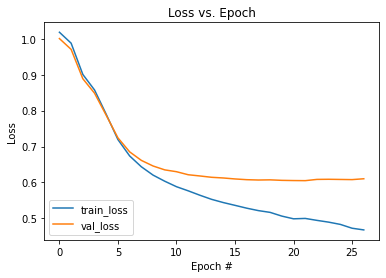

In [38]:
plt.plot(history.history["custom_loss"], label="train_loss")
plt.plot(history.history["val_custom_loss"], label="val_loss")
plt.title("Loss vs. Epoch")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")

plt.savefig("loss.png")
plt.show()

In [39]:
run.log({"Loss":wandb.Image("loss.png")})

In [40]:
# Save the weights of the model for better reproducibility
main_model.encoder.save_weights("encoder.h5")
main_model.decoder.save_weights("decoder.h5")

artifact = wandb.Artifact('model-weights', type='model')

# Add a file to the artifact's contents
artifact.add_file('encoder.h5')
artifact.add_file('decoder.h5')

# Save the artifact version to W&B and mark it as the output of this run
run.log_artifact(artifact)

# Catpions

In [62]:
# Test the decoder
encoder = CNN_Encoder(EMBEDDING_DIM, 1)
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE, 1)

for image, caption in train_ds.take(1):
    features = encoder(tf.expand_dims(image[1],0))
    print(f"ENCODER OUTPUT: {features.shape}")
    hidden = decoder.reset_state()
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 1)
    predictions, hidden, attn_weights = decoder(dec_input, features, hidden)
    print(f"PREDICTION: {predictions.shape}")
    print(f"HIDDEN: {hidden.shape}")
    print(f"ATTENTION: {attn_weights.shape}")

ENCODER OUTPUT: (1, 64, 512)
PREDICTION: (1, 10001)
HIDDEN: (1, 256)
ATTENTION: (1, 64, 1)


In [63]:
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

In [70]:
def evaluate(image):
    #                          max_length  64
    attention_plot = np.zeros((72, KERNEL))

    hidden = decoder.reset_state()

    img = tf.expand_dims(load_img(image), 0)
    features = encoder(img)

    dec_input = tf.expand_dims([tokenizer.word_index['<start>']], 0)
    result = []

    for i in range(72):
        predictions, hidden, attention_weights = decoder(dec_input, features, hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        result.append(tokenizer.index_word[predicted_id])

        if tokenizer.index_word[predicted_id] == '<end>':
            return result, attention_plot

        dec_input = tf.expand_dims([predicted_id], 0)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [71]:
def plot_attention(image, result, attention_plot):
    temp_image = np.array(Image.open(image))

    fig = plt.figure(figsize=(10, 10))

    len_result = len(result)
    for l in range(len_result):
        temp_att = np.resize(attention_plot[l], (8, 8))
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        ax.set_title(result[l])
        img = ax.imshow(temp_image)
        ax.imshow(temp_att, cmap='gray', alpha=0.6, extent=img.get_extent())

    plt.tight_layout()
    plt.show()

In [73]:
from PIL import Image

Prediction Caption: an surfer on a big wave <end>


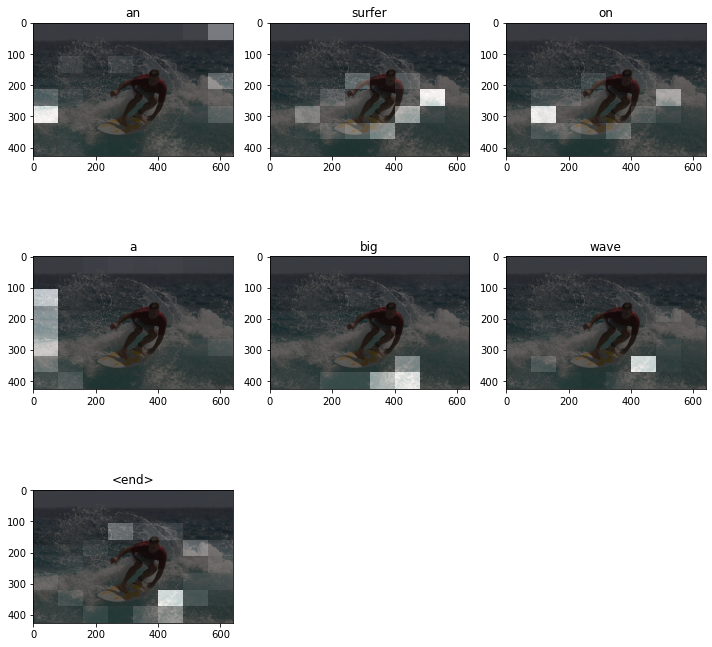

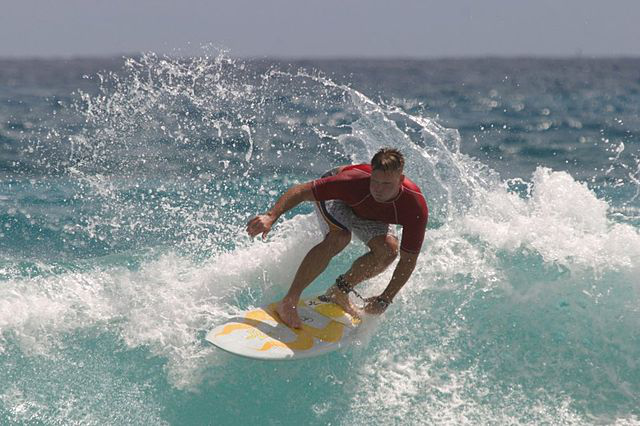

In [77]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_extension = image_url[-4:]
image_path = tf.keras.utils.get_file('image'+image_extension,
                                     origin=image_url)

result, attention_plot = evaluate(image_path)
print ('Prediction Caption:', ' '.join(result))
plot_attention(image_path, result, attention_plot)
# opening the image
Image.open(image_path)